# VeloStars Case Study
This notebook aims at reproducing results obtained by SF on a simple example found [here](https://trailhead.salesforce.com/content/learn/projects/put-predictions-into-action-with-next-best-action/define-and-build-a-prediction?trailmix_creator_id=rajivpatel&trailmix_slug=einstein-champions). On this example, SF is able to reach an overall AuROC of 94%. It seems that this result is quite high, however, we will still try to beat this result using statistical machine learning techniques. 

For reference, SF Einstein relies on XGboost for classification work. 

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, auc, roc_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV

In [2]:
from data_cleaning import (feature_deletion, feature_transform_notNan, non_numerical_features, feature_ordinalEncoding)

## 0. Load the dataset 

In [3]:
df = pd.read_csv("Contact.csv")
df.head()

,Id,IsDeleted,MasterRecordId,AccountId,Salutation,FirstName,LastName,OtherStreet,OtherCity,OtherState,...,Bikes_Purchased__c,Homeowner__c,Income_Range__c,Joined_Group_Rides__c,Occupation__c,Service_Visits__c,Signed_Up_For_Races__c,Total_Spent__c,VeloStars_Member__c,First_Purchase__c
0,0030900000PQSLEAA5,0,NaN,000000000000000AAA,NaN,Daisy,Pashbee,NaN,NaN,NaN,...,0.0,0,"$100,000 to $124,999",1,Farming/Fishing,17.0,0,185.0,0,2012-09-01 00:00:00
1,0030900000PQSLFAA5,0,NaN,000000000000000AAA,NaN,Beauregard,Pidgeon,NaN,NaN,NaN,...,3.0,0,"$200,000 or more",0,Sales/Office,20.0,0,1848.0,0,2012-01-10 00:00:00
2,0030900000PQSLGAA5,0,NaN,000000000000000AAA,NaN,Bridie,Rylatt,NaN,NaN,NaN,...,11.0,0,"$50,000 to $59,999",0,Farming/Fishing,24.0,0,2418.0,0,2003-09-16 00:00:00
3,0030900000PQSLHAA5,0,NaN,000000000000000AAA,NaN,Ava,Carletti,NaN,NaN,NaN,...,7.0,1,"$30,000 to $34,999",0,Management,23.0,0,3602.0,0,1999-05-16 00:00:00
4,0030900000PQSLIAA5,0,NaN,000000000000000AAA,NaN,Sheffield,Ivimy,NaN,NaN,NaN,...,1.0,1,"$100,000 to $124,999",0,Farming/Fishing,22.0,0,1384.0,0,2000-05-24 00:00:00


## I. Basic Data Preprocessing 
A few pre-processing functions have been encoded into the file `data_cleaning.py`. The description of each function can be found in the aforementioned file.    
The basic idea is: 
1. Delete the useless features for prediction (i.e features with all Nans, features that are associated to a randomly given ID ...). 
2. Transform some features such as phone number of email address. Someone's phone number is not usefull in its essence, however, the fact of knowning that the client was willing to give his phone number might be.
3. Check the type of all features: the algorithms that are used required numerical data, hence, some `object` features need to be encoded. Ordinal encoding is used. A special attention is given to dates: only the year's data is kept. 
4. Check that there are no undefined values. If so replace them by their median or mean (or use another method). 
5. Some algorithm respond badly to outliers (especially Ridge regression). Hence, some methods were prepared to remove outliers. However, one might know that there exist a wide range of outlier removal algorithms, hence which method to use is considered as a hyperparameter of the model, and can be tuned in later sections of the notebook. 

In [4]:
# delete some selected columns (associated to id) and drop the call filled with NaNs
columns_to_delete = ['Id', 'IsDeleted', 'AccountId', 'FirstName', 'LastName','MailingStreet', 'MailingCity', 'MailingState','OwnerId', 'CreatedDate', 'CreatedById', 'LastModifiedDate', 'LastModifiedById', 'SystemModstamp', 'CleanStatus', 'IndividualId']
df = feature_deletion(df, columns_to_delete)

Features Kept: ['MailingPostalCode' 'Phone' 'Email' 'HasOptedOutOfEmail'
 'HasOptedOutOfFax' 'DoNotCall' 'Age__c' 'Bike_Type_Interest__c'
 'Bikes_Purchased__c' 'Homeowner__c' 'Income_Range__c'
 'Joined_Group_Rides__c' 'Occupation__c' 'Service_Visits__c'
 'Signed_Up_For_Races__c' 'Total_Spent__c' 'VeloStars_Member__c'
 'First_Purchase__c']


In [5]:
# reduce information contained in phone and email 
df = feature_transform_notNan(df, "Phone", "hasPhone")
df = feature_transform_notNan(df, "Email", "hasEmail")

In [6]:
# need to convert the features that are not numerical so we print a summary of the different features' type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MailingPostalCode       5000 non-null   int64  
 1   HasOptedOutOfEmail      5000 non-null   int64  
 2   HasOptedOutOfFax        5000 non-null   int64  
 3   DoNotCall               5000 non-null   int64  
 4   Age__c                  5000 non-null   float64
 5   Bike_Type_Interest__c   5000 non-null   object 
 6   Bikes_Purchased__c      5000 non-null   float64
 7   Homeowner__c            5000 non-null   int64  
 8   Income_Range__c         5000 non-null   object 
 9   Joined_Group_Rides__c   5000 non-null   int64  
 10  Occupation__c           5000 non-null   object 
 11  Service_Visits__c       5000 non-null   float64
 12  Signed_Up_For_Races__c  5000 non-null   int64  
 13  Total_Spent__c          5000 non-null   float64
 14  VeloStars_Member__c     5000 non-null   

In [7]:
# print features that will require special attention
non_numerical_features(df)

array(['Bike_Type_Interest__c', 'Income_Range__c', 'Occupation__c',
       'First_Purchase__c'], dtype=object)

In [8]:
# ordinal encoding of the categorical features 
df, mapping_bike_type = feature_ordinalEncoding(df, 'Bike_Type_Interest__c')
df, mapping_income_range = feature_ordinalEncoding(df, 'Income_Range__c')
df, mapping_occupation = feature_ordinalEncoding(df, 'Occupation__c')

In [9]:
# convert date string to a data object and only keep the year 
df["First_Purchase__c"] = pd.to_datetime(df["First_Purchase__c"])
df["First_Purchase__c"] = df["First_Purchase__c"].apply(lambda x: x.year)

In [10]:
# this is the point were null features should be taken care of, however, as seen previously, there are no null features 

<AxesSubplot:>

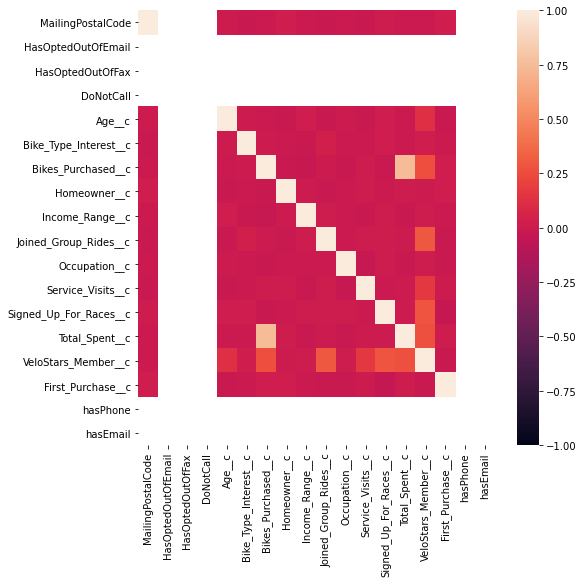

In [11]:
# we take a look at the correlation matrix to remove any potential correlated features
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(),vmin=-1.0, vmax=1.0, xticklabels=df.columns, yticklabels=df.columns)

In [12]:
# drop useless columns revealed by the auto-correlation heat-map
df = df.drop(columns=['HasOptedOutOfEmail', 'HasOptedOutOfFax', 'DoNotCall', 'hasPhone',  'hasEmail'])

## III. Some first insights 
Before starting the analysis, to mimic SalesForce example, only some contacts are kept: 
- contacts that have a VeloStars membership
- contacts that first bought a bike after 2015 and that do not have a VeloStars membership
These two observations will form our training/testing set. However, before training, one should take a look at the data to answer a few questions: 
- are the two classes well balanced ? 
- is there significant differences between the two classes (i.e elements are 

In [13]:
# seperate the two populations (VeloStars members and non-Velostars members)
treated = df[df['VeloStars_Member__c'] == 1]
control = df[df['VeloStars_Member__c'] == 0][df['First_Purchase__c'] >= 2015]

<ipython-input-13-18e01baaa217>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control = df[df['VeloStars_Member__c'] == 0][df['First_Purchase__c'] >= 2015]


In [14]:
# check the balance of each classes 
print("Percenage of people with membership card: " + "{:.02f}".format(treated.shape[0]/(treated.shape[0] + control.shape[0]) *100) + "%")

Percenage of people with membership card: 46.10%


C:\Users\pmansat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pmansat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


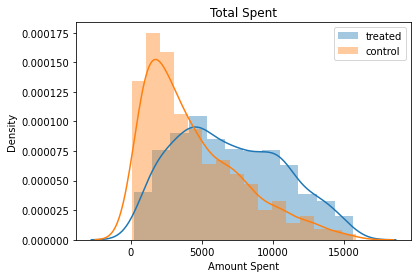

In [15]:
# membership and total spent have a high positive correlation, we should investigate if the difference is important
ax = sns.distplot(treated['Total_Spent__c'], hist=True, label='treated');
ax = sns.distplot(control['Total_Spent__c'], hist=True, label='control')
ax.set(title='Total Spent',xlabel='Amount Spent', ylabel='Density')
plt.legend()
plt.show()

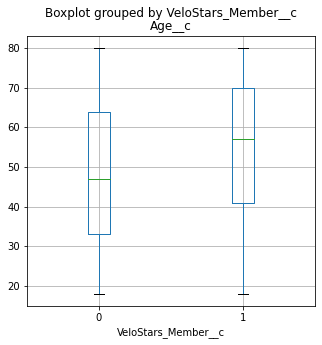

In [16]:
# age seemed to be highly correlated to membership, we investigate if the data corroborates such a difference 
df.boxplot(by='VeloStars_Member__c', column='Age__c', figsize = [5, 5], grid=True)
plt.show()

## Predictions using statistical machine learning techniques 
It is time to make some predictions. To start gently, Logistic Regression, with no adds-on is used. 
### A. Logistic Regression

In [17]:
# put the previously seperated population back together
data_train = treated.merge(control, how='outer')

In [18]:
# get the targets 
y = data_train['VeloStars_Member__c']

# get the features
result = data_train.drop(columns=['VeloStars_Member__c'])
X = result

In [19]:
# create and predict a model using logistic regression
logistic = LogisticRegression(solver='lbfgs')
precision = cross_val_score(logistic, X, y, cv=10, scoring="precision")
recall = cross_val_score(logistic, X, y, cv=10, scoring="recall")

C:\Users\pmansat\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pmansat\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

In [20]:
# predict the probabilities with a cross validationn
y_pred = cross_val_predict(logistic, X, y, cv=10, method="predict_proba")
# compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
# compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr)

C:\Users\pmansat\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pmansat\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

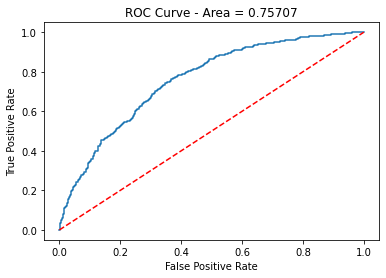

In [21]:
# Plot the ROC curve 
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc_score));

**Final Observations:** SF Einstein was able to get more than 90% AuROC, hence a 75% AuROC pales in comparaison. However, this result is still honorable considering no data processing was applied. This goes into the sense that SF uses XGboost with multiple regression trees. Hence, SF is able to remove useless features (something that had to be done manually before). 

### B. Ridge Regression
Ridge Regression is now used to try to improve Logistic Regression used. However, this time, a large pannel of "adds-on" is tested in order to reach SF's result.  

In [22]:
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import quantile_transform

In [24]:
def pre_processing (data, norm=False, std=False) : 
    """
    Apply a transformation to the data. 
    Options are standardization or normalization (using L2 norm).
    By default : no transformation applied to data 
    """
    result = data
    if norm : 
        result = Normalizer().fit_transform(data)
    if std : 
        result = StandardScaler().fit_transform(data)
    return result

In [25]:
def prepare_data_pca (df, norm=False, std=False, power_trans=False, cov_rem=False, DBSCAN_rem=False, quant_rem=False) : 
    """
    Prepare the data for different rounds of trainings using Ridge Regression. Linear Regression techniques are quite 
    sensitive to outliers, hence a pipeline is proposed to remove them. In essence, 3 algorithms can be used to remove 
    outliers: (1) ElipticEnvelop is used to detect points that deviate from a Gaussian setting, (2) DBSCAN is used to 
    detect points that lie outside clusters found by DBSCAN, and (3) quantile transformation tests if a point is 
    used as a measure of improbability. 
    :param df: the dataframe (targets + observations) to which the transformation must be applied 
    :param norm: boolean that states if the data should be normalized 
    :param std: boolean that states if the data should be standardized 
    :param power_trans: boolean that the states if data should be going through a power transformer
    :param cov_rem: boolean that states if outliers should be removed using ElipticEnvelop
    :param DBSCAN_rem: boolean that states if outliers should be removed using DBSCAN 
    :param quant_rem: boolean that states of outliers should be remouved using a quantile transformer
    :return: the observations and the targets
    """
    
    # prepares the target
    y = df['VeloStars_Member__c'].values

    # prepare the data 
    df = df.drop(columns=['VeloStars_Member__c'])
    X = df.values
    
    # methods to remove outliers 
    if cov_rem : 
        cov = EllipticEnvelope(random_state=0).fit(X)
        outliers_cov = cov.predict(X)
        X = X[outliers_cov != -1]
        y = y[outliers_cov != -1] 
    
    if DBSCAN_rem : 
        outlier_detection = DBSCAN(
              eps = 1000,
              metric="euclidean",
              min_samples = 3)
        clusters = outlier_detection.fit_predict(X)
        X = X[clusters != -1]
        y = y[clusters != -1]
        print(clusters[clusters != -1].shape)
        
        
    if quant_rem : 
        X = quantile_transform(X, n_quantiles=10, random_state=0, copy=True)
        
    # applies a power transform to the data 
    if power_trans : 
        pt = PowerTransformer()
        X = pt.fit_transform(X)
     
    # if the data has to be standardize or normalize 
    X = pre_processing(X, norm, std)

    return X, y

In [26]:
def build_poly(x, degree):
    """
    Used to send the data in higher dimension using polynomial expansion
    :param x: the datapoint
    :param degree: the degree to which the datapoint is sent 
    """
    # send features in high dimension using polynomial expansion 
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

def build_k_indices(y, k_fold, seed):
    """
    Builds k-indices for k-fold.
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [423]:
def cross_validation_and_training (y, x, learning_param_range, degrees, n_components):
    """
    Given a set of hyper-parameters, train multiple models using different parameter combinations, and returns the combination
    that yielded to the best result. 
    :param y: target 
    :param x: data
    :param learning_param_range: the learning parameter range for ridge regression
    :param n_components: the number of components used to reduce the number of features using PCA 
    """
    scores = []
    pcas = []
    minPCA_score_global = 9999999
    minPCA_value = n_components[-1]
    x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.3, random_state=3)
    for degree in degrees : 
        scores_pca = []
        for n_component in n_components : 
            pca = PCA(n_components = n_component)
            x_train_pca = pca.fit_transform(x_train, y_train)
            x_validation_pca = pca.transform(x_validation)
            polyTrain = build_poly(x_train_pca, degree)
            polyValidation = build_poly(x_validation_pca, degree)
            model = RidgeClassifierCV(alphas=learning_param_range, cv=4).fit(polyTrain, y_train)
            #print(model.score(polyTest, y_test))
            y_pred = model.predict(polyValidation) 
            error = mean_squared_error(y_validation, y_pred)
            scores_pca.append(error)
            
        minPca_Index = np.argmin(scores_pca)
        minPca_score = scores_pca[minPca_Index]
        
        #if (minPca_score < minPCA_score_global) : 
        #   minPCA_value = n_components[minPca_Index]
        scores.append(scores_pca[minPca_Index])
        pcas.append(n_components[minPca_Index])
    minIndex = np.argmin(scores)
    minDegree = degrees[minIndex]
    minScore = scores[minIndex]
    minPCA_value = pcas[minIndex]
    return minDegree, minScore, minPCA_value

In [424]:
import warnings
warnings.filterwarnings('ignore')
minDegree, minScore, minPCA_value = cross_validation_and_training (y, X, [0.0001, 0.01, 0.1, 1], [1,2, 4, 5, 6, 7, 8], [10])

In [474]:
import warnings
warnings.filterwarnings('ignore')
def classic_score (df) : 
    """
    Given a pre-set set of parameters, trains a model, keeps the model that had the best performance, and returns the 
    AuROC score of the best performing model. 
    """
    learning_params = [1e-100, 1e-20, 1e-10, 1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 3]
    X, y = prepare_data_pca(df, norm=False, std=True, power_trans=False,cov_rem=False, DBSCAN_rem=False, quant_rem=False)
    x_train,x_test,y_train,y_test=train_test_split(X,y, test_size=0.3,random_state=3)
    minDegree, minScore, minPCA_value = cross_validation_and_training (y_train, x_train, learning_params, [1, 2, 3, 4], [5,10, X.shape[1]])
    print("Min pca value : ", minPCA_value)
    print("Min degree : ", minDegree)
    pca = PCA(n_components = minPCA_value)
    x_train_pca = pca.fit_transform(x_train, y_train)
    x_test_pca = pca.transform(x_test)
    polyTrain = build_poly(x_train_pca, minDegree)
    polyTest = build_poly(x_test_pca, minDegree)
    model = RidgeClassifierCV(alphas=learning_params).fit(polyTrain, y_train)
    y_prediction = model.predict(polyTest)
    print("AuROC: " + "{:.2f}".format(roc_auc_score(y_test, y_prediction)*100) + "%")


In [475]:
classic_score(data_train)

Min pca value :  12
Min degree :  4
AuROC: 89.84%


**Final Observations:** Ridge regression, along with multiple adds-on is able to increase the AuROC score, however, not SalesForce level. 

Below another method is tried out using kernel expansion (instead of polynomial expansion). However, results are not drastically better. 

In [480]:
from sklearn.kernel_approximation import Nystroem
from numpy import savetxt
def kernel_test_nystroem (gammas, n_components) : 
    auroc_saved = []
    for g in gammas : 
        for n in n_components :
            X, y = prepare_data_pca(data_train, norm=False, std=True, power_trans=False, cov_rem=False, DBSCAN_rem=True, quant_rem=False )
            x_train,x_test,y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=3)
            pca = PCA(n_components = x_train.shape[1])
            x_train = pca.fit_transform(x_train, y_train)
            x_test = pca.transform(x_test)
            
            feature_map_nystroem = Nystroem(gamma=g, random_state=1, n_components=n)
            x_train = feature_map_nystroem.fit_transform(x_train)
            x_test = feature_map_nystroem.transform(x_test)
            #x_train,x_test,y_train,y_test=train_test_split(data_transformed,y, test_size=0.3,random_state=3)

            model = RidgeClassifierCV(alphas=[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2,3, 4, 5]).fit(x_train, y_train)
            final_score = model.score(x_test, y_test)
            y_prediction = model.predict(x_test)
            auroc = roc_auc_score(y_test, y_prediction)
            auroc_saved.append(auroc)
    return auroc_saved
result = kernel_test_nystroem([0.02], [2401])
np.max(result)

(1487,)


0.900462962962963

### C. XGBoost

In [28]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=3)

C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


AuROC: 0.98%


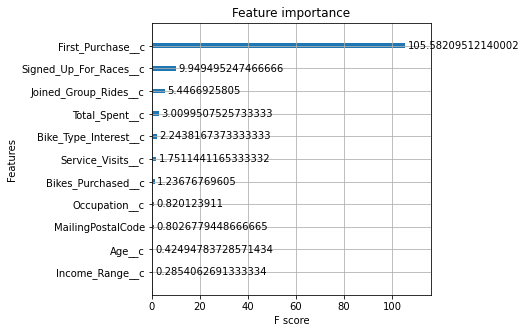

In [36]:
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.8, learning_rate = 0.7,
                max_depth = 10, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
print('AuROC: {:.2f}%'.format(roc_auc_score(y_test, y_pred)))
xgb.plot_importance(xg_reg, importance_type='gain')
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


AuROC: 0.92%


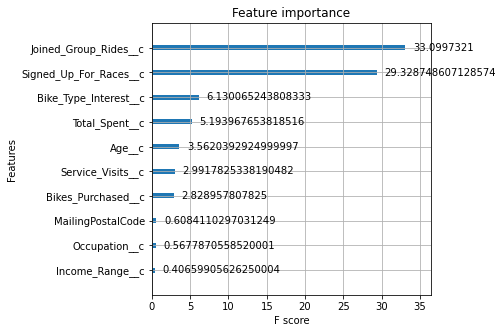

In [37]:
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.8, learning_rate = 0.7,
                max_depth = 10, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train.drop(columns=['First_Purchase__c']), y_train)
y_pred = xg_reg.predict(X_test.drop(columns=['First_Purchase__c']))
print('AuROC: {:.2f}%'.format(roc_auc_score(y_test, y_pred)))
xgb.plot_importance(xg_reg, importance_type='gain')
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

C:\Users\pmansat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pmansat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


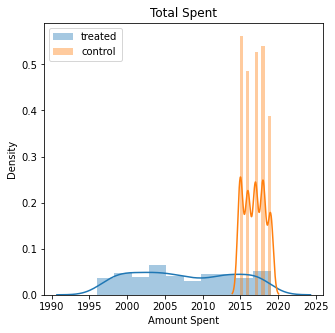

In [34]:
# membership and total spent have a high positive correlation, we should investigate if the difference is important
ax = sns.distplot(treated['First_Purchase__c'], hist=True, label='treated');
ax = sns.distplot(control['First_Purchase__c'], hist=True, label='control')
ax.set(title='Total Spent',xlabel='Amount Spent', ylabel='Density')
plt.legend()
plt.show()

## Conclusion
SF Einstein is able to reach great performance thanks to the techniques it uses: XGBoost is know to obtain great classification results, however, being dependent on regression trees, it also has a greater chance of overfitting. 
Furthermore, regression trees have the ability to detect features that are useless, something that was painfully done by hand in this notebook. 
However, in light of the extremely high score returned by SF, there is a great chance that the algoritm overfitted the problem. 

New deep learning techniques could have been used (such as Google's TabNet) and could have landed similar results such as the one returned by SF. 